<a href="https://colab.research.google.com/github/PallottaEnrico/LegalEval/blob/main/Task_B/Legal_NER_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LegalEval: Understanding Legal Texts
### Task B

This notebook present a solution for the Task B of the LegalEval challenge which is a task of SemEval 2023.

More info about the challenge can be found [here](https://sites.google.com/view/legaleval/home).

[Github link](https://github.com/PallottaEnrico/LegalEval) to our paper and all the utils used here.

Authors:
- Yuri Noviello
- Enrico Pallotta
- Flavio Pinzarrone
- Giuseppe Tanzi

## Task overview

Legal documents have peculiar entities like names of petitioner, respondent, court, statute, provision, precedents, etc. These entity types are not recognized by the standard Named Entity Recognizer. Hence there is a need to develop a Legal NER system. <br>
This would allow to extract information that could be exploited for many legal applications like knowledge graph creation, coreference resolution and in generale to build any query-able knowledge base to allow faster information retrieval.

A list of legal named entities covered is given [here](https://github.com/Legal-NLP-EkStep/legal_NER).

A court judgment can be split into two sections. The first one is the Preamble which contains the names of parties, court, lawyers etc. The judgment text starts after the Preamble.

## Installations and imports

In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install seqeval
!pip install accelerate
!pip install nervaluate
!pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
import json
import os
import urllib.request
from tqdm import tqdm 
import zipfile
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer, TokenClassificationPipeline
from transformers.pipelines import AggregationStrategy
from functools import partial
from nervaluate import Evaluator
from typing import Optional
from google.colab import output
from spacy import displacy, blank

Long and boring functions have been moved to python modules in our github repo.

The main module are:
- [Inference.py](https://github.com/PallottaEnrico/LegalEval/blob/main/Task_B/Inference.py) : contains our implementation of the sliding window method used at inference time and the remap function used for RoBERTa based model to handle cleaning of whitespaces.
- [DataPreparator.py](https://github.com/PallottaEnrico/LegalEval/blob/main/Task_B/DataPreparator.py) : contains the preprocessing function to clean multiple whitespaces and the **NERDataMaker** class that handles everything needed for transforming the training dataframe to a dataset format that the models can take in input.
- [CustoModels.py](https://github.com/PallottaEnrico/LegalEval/blob/main/Task_B/CustomModels.py) : contains the implementation of our proposed models.

In [ ]:
if os.path.exists("LegalEval"):
  !rm -rf LegalEval

!git clone https://github.com/PallottaEnrico/LegalEval.git

from LegalEval.Task_B.Inference import CrfSlidingWindowNERPipeline, SlidingWindowNERPipeline, remap_predictions
from LegalEval.Task_B.DataPreparator import NERDataMaker, clean_data
from LegalEval.Task_B.CustomModels import CustomXLNetForTokenClassification, CustomRobertaForTokenClassification

Cloning into 'LegalEval'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 290 (delta 56), reused 22 (delta 8), pack-reused 190
Receiving objects: 100% (290/290), 70.45 KiB | 7.83 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/MyDrive/project_nlp/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_reproducibility(seed : int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True   

seed = 42
set_reproducibility(seed)

## Dataset download

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    zip_path = os.path.join(data_path, f'{suffix[0]}.zip')

    if not os.path.exists(zip_path):
        print(f"Downloading Dataset {suffix} ... (it may take a while)")
        download_url(url=url_path, output_path=zip_path)
        print("Download completed!")

    zipdata = zipfile.ZipFile(zip_path)
    zipinfos = zipdata.infolist()
    jsons = []
    for zipinfo in zipinfos:
        if 'json' in zipinfo.filename and not ('checkpoint' in zipinfo.filename):
            jsons.append(zipinfo)
    jsons.sort(key=lambda x: x.filename)
    for zipinfo,name in zip(jsons,suffix[1:]):
        zipinfo.filename = f'{name}_{suffix[0]}.json'
        zipdata.extract(zipinfo,data_path)


In [ ]:
# Train data
train_url = 'https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/NER/NER_TRAIN.zip'
download_data(data_path='data_train', url_path=train_url, suffix=['train', 'judgement', 'preamble'])

# Test data
test_url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/NER/NER_DEV.zip"
download_data(data_path='data_test', url_path=test_url, suffix=['test', 'judgement', 'preamble']) 

NER_TRAIN.zip: 2.72MB [00:00, 12.8MB/s]                            


Download completed!


NER_DEV.zip: 762kB [00:00, 6.11MB/s]                            

Download completed!


The training and development set are both provided as separate file for judgements and preambles.

We'll use the development set as our test set and next we'll split the training into training and validation set.

This choice was mandatory given the limited amount of submission that we could do for the challenge.

At the end, the best models have been trained on the full data (training + dev) in order to reach the highest possible score.

In [ ]:
train_judgement = pd.read_json("./data_train/judgement_train.json", encoding='utf-8').drop('id', axis=1)
train_preamble = pd.read_json("./data_train/preamble_train.json", encoding='utf-8').drop('id', axis=1)

test_judgement = pd.read_json("./data_test/judgement_test.json", encoding='utf-8').drop('id', axis=1)
test_preamble = pd.read_json("./data_test/preamble_test.json", encoding='utf-8').drop('id', axis=1)

In [ ]:
train_judgement

,annotations,data,meta
0,"[{'result': [{'value': {'start': 90, 'end': 10...",{'text': ' (7) On specific query by the Bench...,{'source': 'tax_districtcourts judgement https...
1,"[{'result': [{'value': {'start': 26, 'end': 30...",{'text': 'He was also asked whether Agya <span...,{'source': 'criminal_punjab-haryana_high_court...
2,"[{'result': [{'value': {'start': 13, 'end': 25...","{'text': ' 5.2 CW3 Mr Vijay Mishra , Deputy M...",{'source': 'financial_districtcourts judgement...
3,[{'result': []}],{'text': 'You are hereby asked not to carry ou...,{'source': 'civil_bombay_high_court judgement ...
4,"[{'result': [{'value': {'start': 18, 'end': 43...",{'text': 'The pillion rider T.V. Satyanarayana...,{'source': 'motorvehicles_andhra_high_court ju...
...,...,...,...
9430,"[{'result': [{'value': {'start': 202, 'end': 2...",{'text': 'It is prayed in the application that...,{'source': 'civil_districtcourts judgement htt...
9431,"[{'result': [{'value': {'start': 26, 'end': 35...","{'text': 'In the first instance, Mr.A.D.Desai ...",{'source': 'tax_gujarat_high_court judgement h...
9432,"[{'result': [{'value': {'start': 0, 'end': 5, ...","{'text': 'Sikri, J. (as he then was), speaking...",{'source': 'constitution_allahabad_high_court ...
9433,"[{'result': [{'value': {'start': 1, 'end': 17,...",{'text': '(RAJENDRA MAHAJAN) JUDGE AKM M.Cr.C....,{'source': 'industrial&labour_madhya_pradesh_h...


## Data inspection

### Conversion in dataframe format

The files comes in json format so we need to rearrange them into dataframe to have more structured data.

For what we are interested in, we'll consider :
- context : Full text of judgment/preamble
- num : number of entity in the context (useful for faster debugging)
- start, end : indexes of the entities inside the context
- text : entities text, coincide with `context[start[i]:end[i]]`
- label : associated with each entity.
- source : document ID from where the context was extracted, it allow us to have a corrispondency between judgment sentences and their preamble.

In [ ]:
def rearrange_df(df : pd.DataFrame) -> pd.DataFrame:
  #required columns in our dataframe
  cols = ["context", "num", "start", "end", "text", "label","source"]
  # list of lists to create our dataframe
  comp_list = []
  for index, row in tqdm(df.iterrows()):
    temp_list = []
    temp_list.append(row["data"]["text"])
    results = []
    for r in row["annotations"][0]["result"]:
        results.append(r['value'])
    temp_list.append(len(results))
    start = []
    end = []
    text = []
    label = []
    for r in results:
        start.append(r['start'])
        end.append(r['end'])
        text.append(r['text'])
        label.append(r['labels'][0])
    temp_list.append(start)
    temp_list.append(end)
    temp_list.append(text)
    temp_list.append(label)
    temp_list.append(row["meta"]["source"].split(' ')[-1].split('doc/')[-1].replace('/',''))
    comp_list.append(temp_list)

  new_df = pd.DataFrame(comp_list, columns=cols) 
  
  return new_df

In [ ]:
print("Rearranging train..")
train_judgement_df = rearrange_df(train_judgement)
train_preamble_df = rearrange_df(train_preamble)

print("Rearranging test..")
test_judgement_df = rearrange_df(test_judgement)
test_preamble_df = rearrange_df(test_preamble)

Rearranging train..


9435it [00:00, 12068.55it/s]
1560it [00:00, 13702.25it/s]


Rearranging test..


949it [00:00, 12734.17it/s]
125it [00:00, 9318.36it/s]


### Exploration

Quick check of the data and their shapes.

Then we will concatenate the DataFrames of judgments and preambles together.

In [ ]:
train_judgement_df

,context,num,start,end,text,label,source
0,\n\n(7) On specific query by the Bench about a...,2,"[90, 267]","[103, 278]","[Hongkong Bank, Rahul & Co.]","[ORG, ORG]",1556717
1,"He was also asked whether Agya <span class=""hi...",3,"[26, 101, 159]","[30, 105, 174]","[Agya, Kaur, Tarlochan Singh]","[OTHER_PERSON, OTHER_PERSON, OTHER_PERSON]",264463
2,"\n5.2 CW3 Mr Vijay Mishra , Deputy Manager, H...",4,"[13, 44, 62, 121]","[25, 60, 64, 130]","[Vijay Mishra, HDFC Bank, Noida, UP, HDFC Bank]","[WITNESS, ORG, GPE, ORG]",94286093
3,You are hereby asked not to carry out any cons...,0,[],[],[],[],710312
4,The pillion rider T.V. Satyanarayana Murthy al...,1,[18],[43],[T.V. Satyanarayana Murthy],[OTHER_PERSON],903089
...,...,...,...,...,...,...,...
9430,It is prayed in the application that the suit ...,3,"[202, 300, 310]","[226, 306, 329]","[Transfer of Property Act, Sec.34, Specific Re...","[STATUTE, PROVISION, STATUTE]",50183319
9431,"In the first instance, Mr.A.D.Desai contended ...",2,"[26, 270]","[35, 281]","[A.D.Desai, Section 56B]","[OTHER_PERSON, PROVISION]",608373
9432,"Sikri, J. (as he then was), speaking for the m...",2,"[0, 120]","[5, 127]","[Sikri, Rowlatt]","[JUDGE, OTHER_PERSON]",1665576
9433,(RAJENDRA MAHAJAN) JUDGE AKM M.Cr.C. No. 8763/...,4,"[1, 29, 55, 71]","[17, 50, 65, 82]","[RAJENDRA MAHAJAN, M.Cr.C. No. 8763/2009, 04/0...","[JUDGE, CASE_NUMBER, DATE, OTHER_PERSON]",172815162


In [ ]:
test_judgement_df

,context,num,start,end,text,label,source
0,"True, our Constitution has no 'due process' cl...",3,"[10, 108, 160]","[22, 155, 209]","[Constitution, R.C. Cooper v. Union of India, ...","[STATUTE, PRECEDENT, PRECEDENT]",164068662
1,(See Principles of Statutory Interpretation by...,1,[55],[65],[G.P. Singh],[JUDGE],171721750
2,"Their Lordships have said -- ""It is a sound r...",2,"[101, 134]","[108, 140]","[England, Heydon]","[GPE, OTHER_PERSON]",120051893
3,"In para 13 of the plaint, it has been further ...",2,"[252, 313]","[262, 318]","[29/12/2004, Delhi]","[DATE, GPE]",43211240
4,Counsel for appellants contended that who is t...,3,"[169, 275, 294]","[175, 286, 326]","[Rule 2, Section 172, Hyderabad Land Revenue A...","[PROVISION, PROVISION, STATUTE]",78653167
...,...,...,...,...,...,...,...
944,"Apparently, Channaraddi set up his daughters G...",4,"[12, 45, 58, 107]","[23, 53, 66, 121]","[Channaraddi, Gangavva, Mallamma, O.S.No.31/2009]","[OTHER_PERSON, OTHER_PERSON, OTHER_PERSON, CAS...",4181460
945,After the dismissal of the petition for annulm...,1,[89],[110],[F.C.O.P.No.41 of 2012],[CASE_NUMBER],19227079
946,"On 12.07.2018, a letter was received from the ...",5,"[3, 46, 141, 202, 252]","[13, 92, 158, 248, 285]","[12.07.2018, Additional Sessions Judge, Omerga...","[DATE, COURT, ORG, COURT, CASE_NUMBER]",53132052
947,The date on which the measurements were record...,0,[],[],[],[],87575331


In [ ]:
train_preamble_df

,context,num,start,end,text,label,source
0,In The High Court Of Kerala At Ernakulam\n\nCr...,8,"[7, 73, 171, 237, 304, 350, 391, 425]","[40, 83, 182, 251, 311, 365, 400, 436]","[High Court Of Kerala At Ernakulam, T.R.Ajayan...","[COURT, PETITIONER, RESPONDENT, RESPONDENT, LA...",1351251
1,In The Court Of Shri Lokesh Kumar Sharma\n ...,10,"[21, 371, 445, 689, 741, 852, 1007, 1035, 1111...","[40, 383, 470, 698, 764, 869, 1031, 1047, 1121...","[Lokesh Kumar Sharma, Chanakyapuri, Jindal Ste...","[JUDGE, PETITIONER, RESPONDENT, RESPONDENT, RE...",144953764
2,Before The Madurai Bench Of Madras High Court\...,22,"[11, 98, 192, 208, 219, 237, 253, 265, 281, 29...","[45, 115, 204, 215, 233, 249, 261, 277, 295, 3...","[Madurai Bench Of Madras High Court, V.Ramasub...","[COURT, JUDGE, PETITIONER, PETITIONER, PETITIO...",66922949
3,Before The Madurai Bench Of Madras High Court\...,10,"[11, 99, 144, 305, 461, 593, 695, 1335, 1364, ...","[45, 112, 229, 330, 473, 604, 784, 1350, 1375,...","[Madurai Bench Of Madras High Court, T.Sudanth...","[COURT, JUDGE, PETITIONER, RESPONDENT, RESPOND...",1511412
4,1 ...,11,"[85, 435, 614, 773, 879, 997, 1276, 1598, 1658...","[119, 460, 637, 798, 887, 1035, 1296, 1617, 16...","[High Court Of Judicature At Bombay, Motiram M...","[COURT, PETITIONER, RESPONDENT, PETITIONER, PE...",886465
...,...,...,...,...,...,...,...
1555,In The High Court Of Judicature At Madras ...,9,"[7, 110, 157, 234, 248, 267, 736, 822, 886]","[41, 123, 167, 244, 259, 294, 748, 840, 901]","[High Court Of Judicature At Madras, V. Dhanap...","[COURT, JUDGE, PETITIONER, RESPONDENT, RESPOND...",966809
1556,Petitioner:\nKhudiram Das\n\n\tVs.\n\nResponde...,2,"[12, 48]","[24, 68]","[Khudiram Das, State Of West Bengal]","[PETITIONER, RESPONDENT]",679149
1557,In The High Court Of Judicature At Patna\n\n ...,23,"[7, 166, 323, 413, 508, 576, 631, 688, 902, 10...","[40, 181, 337, 500, 568, 623, 680, 765, 911, 1...","[High Court Of Judicature At Patna, Ram Sevak ...","[COURT, PETITIONER, RESPONDENT, RESPONDENT, RE...",20568668
1558,Petitioner:\nThe Automobile Transport(Rajastha...,2,"[16, 76]","[52, 94]","[Automobile Transport(Rajasthan) Ltd., State O...","[PETITIONER, RESPONDENT]",304499


In [ ]:
test_preamble_df

,context,num,start,end,text,label,source
0,$~40\n* In The High Court Of Delhi At New D...,13,"[17, 199, 286, 301, 323, 361, 436, 458, 578, 6...","[49, 225, 295, 317, 352, 381, 446, 480, 594, 6...","[High Court Of Delhi At New Delhi, Oriental In...","[COURT, PETITIONER, LAWYER, LAWYER, LAWYER, LA...",32733384
1,1\n\n ...,7,"[117, 328, 451, 701, 824, 1011, 1130]","[139, 354, 467, 726, 851, 1039, 1146]","[Supreme Court Of India, Parmar Samantsinh Ume...","[COURT, PETITIONER, RESPONDENT, PETITIONER, RE...",174348885
2,R/Scr.A/9089/2017 ...,7,"[91, 236, 938, 1038, 1149, 1190, 1329]","[125, 249, 968, 1054, 1158, 1202, 1342]","[High Court Of Gujarat At Ahmedabad, J.B.Pardi...","[COURT, JUDGE, PETITIONER, RESPONDENT, LAWYER,...",42368648
3,High Court Of Judicature For Rajasthan Bench A...,5,"[0, 163, 716, 752, 812]","[85, 187, 734, 794, 846]",[High Court Of Judicature For Rajasthan Bench ...,"[COURT, PETITIONER, RESPONDENT, RESPONDENT, RE...",137053871
4,1\n\n In T...,15,"[47, 275, 402, 728, 888, 982, 1054, 1146, 1324...","[81, 286, 420, 736, 951, 1027, 1115, 1293, 133...","[High Court Of Judicature At Madras, S.Manikum...","[COURT, JUDGE, JUDGE, PETITIONER, RESPONDENT, ...",138695831
...,...,...,...,...,...,...,...
120,Carbp-196 of 2016.odt\n\n\nrrpillai\n ...,51,"[66, 373, 483, 573, 610, 649, 916, 1026, 1116,...","[100, 385, 495, 595, 634, 659, 926, 1038, 1138...","[High Court Of Judicature At Bombay, Yogesh Me...","[COURT, PETITIONER, RESPONDENT, RESPONDENT, RE...",89717025
121,dss 1 Judgment-wp...,42,"[78, 207, 290, 366, 420, 444, 466, 502, 520, 5...","[112, 210, 304, 380, 435, 460, 479, 514, 534, ...","[High Court Of Judicature At Bombay, Xyz, Unio...","[COURT, PETITIONER, RESPONDENT, LAWYER, LAWYER...",73406697
122,In The High Court Of Kerala At Ernakulam\n ...,17,"[7, 116, 430, 577, 611, 638, 670, 799, 929, 11...","[40, 132, 447, 588, 622, 648, 681, 813, 943, 1...","[High Court Of Kerala At Ernakulam, Anil K.Nar...","[COURT, JUDGE, PETITIONER, LAWYER, LAWYER, LAW...",77964072
123,"High Court Of Judicature At Allahabad, Lucknow...",16,"[0, 175, 213, 254, 269, 295, 309, 320, 458, 50...","[52, 184, 226, 268, 287, 308, 319, 337, 479, 5...","[High Court Of Judicature At Allahabad, Luckno...","[COURT, PETITIONER, RESPONDENT, LAWYER, LAWYER...",63963239


Preamble and judgement are concatenated (and shuffled) since on the actual test there won't be any distinction.

In [ ]:
train_df = pd.concat([train_preamble_df, train_judgement_df], ignore_index=True)

test_df = pd.concat([test_preamble_df, test_judgement_df], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

print("Training shape :", train_df.shape)
print("Test shape :", test_df.shape)

Training shape : (10995, 7)
Test shape : (1074, 7)


In [ ]:
def labels_frequency(df : pd.DataFrame):
  labels = [item for sublist in df['label'] for item in sublist]
  colors = dict(zip(set(labels), plt.cm.rainbow(np.linspace(0, 1, len(set(labels))))))
  for c in set(labels):
    plt.hist([labels[i] for i in range(len(labels)) if labels[i] == c], color = colors[c])
  plt.rcParams["figure.figsize"] = (20,5)
  plt.xlabel('Legal named entities')
  plt.ylabel('Count')
  plt.show()

Let's check the distribution of entities in our training and test dataset.

They don't look actually the same but in both there's a general trend.

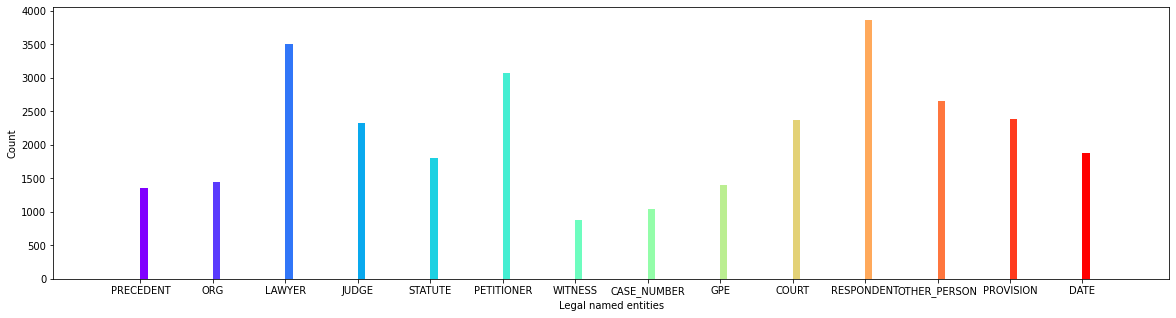

In [ ]:
labels_frequency(train_df)

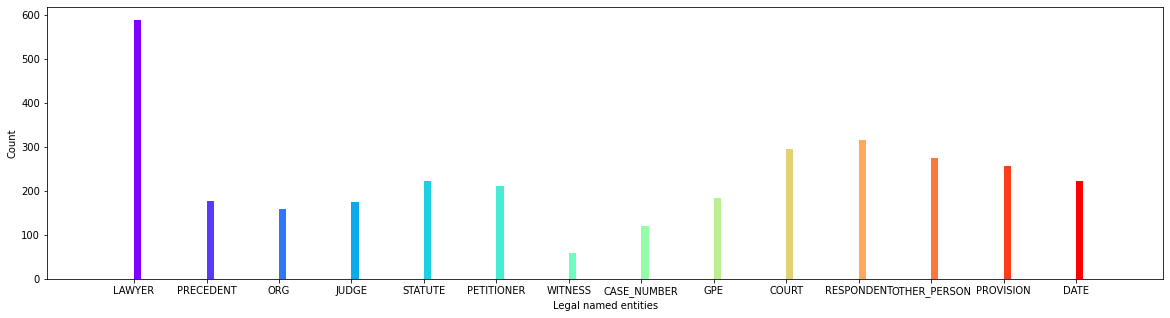

In [ ]:
labels_frequency(test_df)

In [ ]:
def labels_average_len(df : pd.DataFrame):
  labels = set([item for sublist in df['label'] for item in sublist])

  labels_avg_len = []
  labels_count = dict.fromkeys(labels, 0)
  labels_text_len = dict.fromkeys(labels, 0)
  labels_avg_len = dict.fromkeys(labels, 0)
  for i, row in df.iterrows():
    for j , text in enumerate(row['text']):
      labels_count[row['label'][j]] += 1
      labels_text_len[row['label'][j]] += len(text.split(" "))

  for label in labels:
    labels_avg_len[label] = labels_text_len[label] // labels_count[label]

  
  return dict(sorted(labels_avg_len.items(), key=lambda x:x[1], reverse=True))

Let's check also the average length in terms of word (not tokens) for each entity class.

Again train and test are pretty similar from this point of view.

In [ ]:
labels_average_len(train_df)

{'PRECEDENT': 9,
 'COURT': 7,
 'CASE_NUMBER': 4,
 'RESPONDENT': 4,
 'ORG': 2,
 'LAWYER': 2,
 'STATUTE': 2,
 'PETITIONER': 2,
 'PROVISION': 2,
 'JUDGE': 1,
 'WITNESS': 1,
 'GPE': 1,
 'OTHER_PERSON': 1,
 'DATE': 1}

In [ ]:
labels_average_len(test_df)

{'PRECEDENT': 11,
 'RESPONDENT': 7,
 'COURT': 6,
 'LAWYER': 3,
 'PETITIONER': 3,
 'CASE_NUMBER': 3,
 'ORG': 2,
 'JUDGE': 2,
 'STATUTE': 2,
 'PROVISION': 2,
 'WITNESS': 1,
 'GPE': 1,
 'OTHER_PERSON': 1,
 'DATE': 1}

## Train val split

The 10\% of training data will be used as validation, it will have more or less the same number of samples as the test set.

In [ ]:
from sklearn.model_selection import train_test_split

train_df , val_df = train_test_split(train_df, test_size = 0.1)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Training shape :", train_df.shape)
print("Validation shape :", val_df.shape)

Training shape : (9895, 7)
Validation shape : (1100, 7)


## Training & Evaluation functions



All the functions used during the training and evaluation phases are in this section, we tried to make them as generic as possible in order to have a modular, reusable and maintainable code.

This function allow us to see the progress of the model training on the validation set, we mainly keep track of the F1 score as it's the final evaluation metric. 

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds, label_names, CRF : bool = False):

    if not CRF:
      logits, labels = eval_preds
      predictions = np.argmax(logits, axis=-1)

      # Remove ignored index (special tokens) and convert to labels
      true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
      true_predictions = [
          [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
          for prediction, label in zip(predictions, labels)
      ]
    else:
      # we need a distinction between using or not CRF layer since it directly
      # returns the most probable label and not the logits.
      predictions, labels = eval_preds
    
      true_labels = [[label_names[l] for l in label if l >= 0] for label in labels]
      true_predictions = [
          [label_names[p] for (p, l) in zip(prediction, label) if l >= 0]
           for prediction, label in zip(predictions, labels) 
      ]
    
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels, mode = 'strict')
    
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
batch_size=8 # low value given the limited memory of colab

training_args = TrainingArguments(
    output_dir = "",
    evaluation_strategy = "epoch",  
    save_strategy = "no", # no checkpoint saving, it consumes too much drive memory
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    fp16 = True, # speed up a bit the training
    save_steps = 0,
    eval_steps = 1, # evaluate at each epoch
    learning_rate = 5e-5,
    auto_find_batch_size = True, # starts from given batch size, decreases it if needed
    report_to = 'all',
    optim = 'adamw_torch', # avoids optimizer warnings
    num_train_epochs = 3,
    weight_decay = 0.01,
    warmup_ratio = 0.1 # a bit of warmup to avoid weight initialization problems
)

In [ ]:
def exec_train_pipeline(model_name : str,
                        train_df : pd.DataFrame,
                        val_df : pd.DataFrame,
                        save_dir : str,
                        max_len : int = 512,
                        epochs : int = 3,
                        custom_layers : Optional[dict] = {}):
  """
    Executes all the process from data converions and tokenization to model definition and training.
    
    @params:
      model_name : name of a pretrained model to load.
      train_df : training set
      val_df : validation set
      save_dir : directory in which the model will be saved
      max_len : dimension of the sliding window, it must be less than or equal to the maximum lenght allowed by the given model.
      epochs : number of training epochs
      custom_layers : it contains the information to customize your model, it allows you to set the number of BiLSTM layers and a CRF layer.
                      sample of usage can be found in "Custom models" section.  
  """

  # avoid possible confilct with other training
  train_df2 = train_df.copy()
  val_df2 = val_df.copy()

  # Check if the CRF layer is used in custom layers.
  CRF = ('CRF' in custom_layers.keys()) and (custom_layers['CRF'] == True)

  # tokenizer must be defined before since we'll use it in the data preparation step
  print(f"Tokenizer {model_name} loading")
  tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True, use_fast=True)
  tokenizer.padding_side = 'right'

  # in case of tokenizer that consider also whitespaces, we clean the data
  # this happens for example with RoBERTa that reaches only 0.41 f1 score if trained on data that are not cleaned
  if tokenizer.tokenize(' ') != []:
    train_df2 = train_df2.apply(clean_data, axis = 1)
    val_df2 = val_df2.apply(clean_data, axis = 1)

  # the NERDataMaker class handles everything needed
  # from tokenization to sliding window for training.
  print("Processing training data")
  dm_train = NERDataMaker(train_df2, tokenizer=tokenizer)
  train_ds = dm_train.as_hf_dataset(window_length = max_len, sl_window = True, CRF = CRF)
  print("Processing validation data")
  dm_val = NERDataMaker(val_df2, tokenizer=tokenizer)
  val_ds = dm_val.as_hf_dataset(window_length = max_len, sl_window = True, CRF = CRF)
  
  print(f"Loading model {model_name}")
  if custom_layers == {}:
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(dm_train.unique_entities),
        id2label=dm_train.id2label,
        label2id=dm_train.label2id
    )
  else:
    if 'roberta' in model_name.lower():
      model = CustomRobertaForTokenClassification.from_pretrained(
          model_name,
          num_labels=len(dm_train.unique_entities),
          id2label=dm_train.id2label,
          label2id=dm_train.label2id,
          custom_layers = custom_layers
      )
    elif 'xlnet' in model_name.lower():
      model = CustomXLNetForTokenClassification.from_pretrained(
          model_name,
          num_labels=len(dm_train.unique_entities),
          id2label=dm_train.id2label,
          label2id=dm_train.label2id,
          custom_layers = custom_layers
      )
    else:
      raise Exception("There's no custom implementation for the model name provided")

  # set actual saving directory
  training_args.output_dir = os.path.join(root_dir, save_dir)
  training_args.num_train_epochs = epochs

  # CRF doesn't allow standard -100 as pad token
  if CRF:
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, label_pad_token_id=-1)
  else:
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

  print("Training starts")
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds, 
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = partial(compute_metrics, label_names = dm_train.id2label, CRF = CRF) 
  )

  trainer.train()

  if os.path.exists(root_dir):
    trainer.save_model(os.path.join(root_dir, save_dir))

In [ ]:
# adapt ground truth to be used for test evaluation 
def get_ground_truth(df : pd.DataFrame):
    ground_truth = []
    
    for _, row in df.iterrows():
        current = []
        
        for start,end,label in zip(row['start'], row['end'], row['label']):
            ent = {"label": label,
                   "start": start,
                   "end": end}
            current.append(ent)
        ground_truth.append(current)
        
    return ground_truth

# get prediction directly from raw text using sliding window pipeline
def get_prediction(model, tokenizer, df):
    predictions = []
    if hasattr(model, 'CRF') and model.CRF:
      pipeline = CrfSlidingWindowNERPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)
    else:
      pipeline = SlidingWindowNERPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", device = 0)
    
    for _, row in df.iterrows():
        current = []
        sentence = row['context']
        entities = pipeline(sentence)
        
        for e in entities:
            current.append({"label": e['entity_group'],
                   "start": e['start'],
                   "end": e['end']})
            
        predictions.append(current)
    return predictions

We use the [nerevaluate](https://pypi.org/project/nervaluate/) library to compute the F1-score for NER as specified by the challenge.

With this evaluation only predictions that exactly match the ground truth in both boundaries and class, are considered as correct. \\
Nontheless we report also F1-score partial that is less strict in the sense that it impose just a partial overlapp between prediction and ground truth. \\



In [ ]:
def exec_eval_pipeline(df : pd.DataFrame,
                       save_dir : str,
                       custom_layers : Optional[dict] = {},
                       clean : bool = False):
  """
    Execute the evaluation on raw texts using a sliding window approach in order to process
    also very long judgements.

    @params:
      df : DataFrame to evaluate.
      save_dir : directory from where to load the trained model.
      custom_layer : if a custom model is used, provide its layer configuration.
      clean : if true, before evaluating clean multiple whitespaces and adapt ground truth boundaries.
              After evaluation adapt prediction boundaries to the original uncleaned text.
    @returns:
      results : DataFrame with average and per class results (Precision, Recall, F1 strict, F1 partial)
      y_pred : predictions of the model (for visualization purpose)
  """

  tokenizer = AutoTokenizer.from_pretrained(os.path.join(root_dir, save_dir), add_prefix_space=True, use_fast=True)
  tokenizer.padding_side = 'right'

  if custom_layers != {}:
    if 'Roberta' in tokenizer.__class__.__name__:
      model = CustomRobertaForTokenClassification.from_pretrained(os.path.join(root_dir, save_dir), custom_layers=custom_layers)
    elif 'XLNet' in tokenizer.__class__.__name__:
      model = CustomXLNetForTokenClassification.from_pretrained(os.path.join(root_dir, save_dir), custom_layers=custom_layers)
    else:
      raise Exception("The model's weights provided do not have a suitable custom model implementation")
  else:
    model = AutoModelForTokenClassification.from_pretrained(os.path.join(root_dir, save_dir))

  y_true = get_ground_truth(df)

  if clean:
    # remove multiple whitespaces
    df_clean = df.apply(clean_data, axis = 1)
    y_pred = get_prediction(model, tokenizer, df_clean)
    # remap predictions to raw texts
    y_pred = remap_predictions(df, df_clean, y_pred)
  else:
    y_pred = get_prediction(model, tokenizer, df)

  # list of unique labels
  tags = set([item for sublist in df['label'] for item in sublist])

  avg_results, per_class_results = Evaluator(y_true, y_pred, tags=tags).evaluate()

  # build the dataframe with all results metrics.  
  results = pd.DataFrame(columns = ['Precision','Recall','F1 strict','F1 partial'])
  
  strict = avg_results['strict']
  
  results.loc['All'] = {'Precision' : round(strict['precision'],3), 'Recall' :round(strict['recall'],3), 'F1 strict' : round(strict['f1'],3), 'F1 partial' : round(avg_results['partial']['f1'],3)}
  results.loc['------'] = {'Precision' : '------', 'Recall' : '------', 'F1 strict' : '------', 'F1 partial' : '------'}

  # per class metrics
  for tag in tags:
    strict = per_class_results[tag]['strict']
    results.loc[tag] = {'Precision' : round(strict['precision'],3), 'Recall' :round(strict['recall'],3), 'F1 strict' : round(strict['f1'],3), 'F1 partial' : round(per_class_results[tag]['partial']['f1'],3)}
  
  return results, y_pred

## Baseline models


The three models trained and evaluated here are a simple transformer with a linear layer on top of it for token classification.

Following the experiments done in the [baselines' paper](https://arxiv.org/pdf/2211.03442.pdf), we tried the best two transformer's based models with RoBERTa and InLegalBERT. \\
In addition we also tried XLNet since it allows to use a higher number of tokens. \\

Some of them, like RoBERTa include by default also a dropout layer (0.1) on top of the transformers, others like XLNet do not.

### BM1 : RoBERTa


RoBERTa will be trained on clean data since it's tokenizer also considers multiple whitespaces.

Without this preprocessing we have seen that RoBERTa is not able to get over 50% of F1-score, this is probably due to the fact that whitespaces drastically reduce the meaningful context in a sliding window of 512 tokens.

#### Training

In [ ]:
exec_train_pipeline(model_name = "roberta-base", train_df = train_df, val_df = val_df, save_dir = "roberta-base")

Tokenizer roberta-base loading


Processing training data


9895it [00:08, 1166.90it/s]


  0%|          | 0/11 [00:00<?, ?ba/s]

Processing validation data


1100it [00:00, 1196.88it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading model roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

Training starts


Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10261
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3849
  Number of trainable parameters = 124077341
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.213500,0.157728,0.723374,0.806013,0.762461,0.958093
2,0.114800,0.130212,0.794872,0.843671,0.818545,0.966742
3,0.076000,0.125925,0.818263,0.864873,0.840923,0.969493


The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1134
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1134
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running 

For RoBERTa we have printed two results of evaluation, in this first one we do the standard evaluation doing inference on raw data, the mean F1 score is 80.8%.

Below, instead, we can see the results of the evaluation doing inference on cleaned data and then remapping boundaries prediction to the raw data.
Thanks to our remapping function we were able to reach 86.7% on the test set.

#### Evaluation

In [ ]:
results , _ = exec_eval_pipeline(test_df, save_dir = 'roberta-base')

results

Token indices sequence length is longer than the specified maximum sequence length for this model (881 > 512). Running this sequence through the model will result in indexing errors


,Precision,Recall,F1 strict,F1 partial
All,0.779,0.839,0.808,0.881
------,------,------,------,------
DATE,0.956,0.977,0.967,0.976
OTHER_PERSON,0.862,0.906,0.883,0.947
CASE_NUMBER,0.723,0.884,0.796,0.829
WITNESS,0.933,0.966,0.949,0.966
GPE,0.747,0.885,0.81,0.852
PROVISION,0.882,0.93,0.906,0.936
PETITIONER,0.616,0.639,0.627,0.798
JUDGE,0.926,0.931,0.928,0.96


##### Eval with special remapping

In [ ]:
results , _ = exec_eval_pipeline(test_df, save_dir = 'roberta-base', clean = True)

results

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


,Precision,Recall,F1 strict,F1 partial
All,0.844,0.89,0.867,0.918
------,------,------,------,------
DATE,0.956,0.982,0.969,0.978
OTHER_PERSON,0.872,0.909,0.89,0.949
CASE_NUMBER,0.725,0.893,0.8,0.833
WITNESS,0.933,0.966,0.949,0.966
GPE,0.747,0.885,0.81,0.852
PROVISION,0.893,0.934,0.913,0.941
PETITIONER,0.869,0.91,0.889,0.951
JUDGE,0.927,0.943,0.934,0.96


### BM2 : InLegalBERT


InLegalBERT is a variant of BERT trained on a corpus of indian legal documents, even if the domain is close to the one of our challenge it didn't gave the best results.

#### Training

In [ ]:
exec_train_pipeline(model_name = "law-ai/InLegalBERT", train_df = train_df, val_df = val_df, save_dir = "InLegalBERT")

Tokenizer law-ai/InLegalBERT loading


Processing training data


9895it [00:18, 542.55it/s] 


  0%|          | 0/11 [00:00<?, ?ba/s]

Processing validation data


1100it [00:01, 1022.63it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading model law-ai/InLegalBERT


Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from th

Training starts


The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10383
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3894
  Number of trainable parameters = 108913949
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.186800,0.155085,0.708808,0.793468,0.748753,0.958818
2,0.114700,0.137897,0.759733,0.813375,0.785639,0.963980
3,0.073400,0.137648,0.779213,0.825505,0.801692,0.967142


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1151
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1151
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
 

#### Evaluation

In [ ]:
results, _ = exec_eval_pipeline(test_df, save_dir = 'InLegalBERT')

results

Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


,Precision,Recall,F1 strict,F1 partial
All,0.82,0.887,0.852,0.901
------,------,------,------,------
DATE,0.9,0.968,0.933,0.948
OTHER_PERSON,0.855,0.895,0.874,0.927
CASE_NUMBER,0.701,0.893,0.785,0.822
WITNESS,0.934,0.983,0.958,0.966
GPE,0.711,0.82,0.761,0.832
PROVISION,0.903,0.938,0.92,0.943
PETITIONER,0.856,0.9,0.878,0.926
JUDGE,0.913,0.96,0.936,0.952


### BM3 : XLNet

XLNet allows to use any input dimension, nonetheless we used 1024 tokens given the memory limitations.

This was our best baseline model, it reached an F1 score on the test set of 87.1% and 86.04% for the actual submission after having been trained on the full dataset.

#### Training

In [ ]:
exec_train_pipeline(model_name = "xlnet-base-cased", train_df = train_df, val_df = val_df, save_dir = "XLNet", max_len = 1024)

Tokenizer xlnet-base-cased loading


Could not locate the tokenizer configuration file, will try to use the model config instead.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.26.0",
  "untie_r":

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_ra

Processing training data


9895it [00:10, 943.30it/s] 


  0%|          | 0/10 [00:00<?, ?ba/s]

Processing validation data


1100it [00:01, 982.93it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading model xlnet-base-cased


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "O",
    "1": "B-CASE_NUMBER",
    "2": "B-COURT",
    "3": "B-DATE",
    "4": "B-GPE",
    "5": "B-JUDGE",
    "6": "B-LAWYER",
    "7": "B-ORG",
    "8": "B-OTHER_PERSON",
    "9": "B-PETITIONER",
    "10": "B-PRECEDENT",
    "11": "B-PROVISION",
    "12": "B-RESPONDENT",
    "13": "B-STATUTE",
    "14": "B-WITNESS",
    "15": "I-CASE_NUMBER",
    "16": "I-COURT",
    "17": "I-DATE",
    "18": "I-GPE",
    "19": "I-JUDGE",
    "20": "I-LAWYER",
    "21": "I-ORG",
  

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/pytorch_model.bin
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You

Training starts


The following columns in the training set don't have a corresponding argument in `XLNetForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `XLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9975
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3741
  Number of trainable parameters = 116740637
You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the training set don't have a corresponding argument in `XLNetForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `XL

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.161300,0.154704,0.754689,0.843433,0.796597,0.964386
2,0.099600,0.133788,0.813440,0.868326,0.839987,0.971408
3,0.082000,0.133788,0.813440,0.868326,0.839987,0.971408


The following columns in the evaluation set don't have a corresponding argument in `XLNetForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `XLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1109
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `XLNetForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `XLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1109
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `XLNetForTokenClassification.forward` and have been ignored: ner_tags, tokens. If ner_tags, tokens are not expected by `XLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *

#### Evaluation

In [ ]:
results, _ = exec_eval_pipeline(test_df, save_dir = 'XLNet')

results

,Precision,Recall,F1 strict,F1 partial
All,0.842,0.901,0.871,0.918
------,------,------,------,------
DATE,0.96,0.978,0.969,0.98
OTHER_PERSON,0.868,0.906,0.887,0.954
CASE_NUMBER,0.698,0.86,0.77,0.822
WITNESS,0.967,1.0,0.983,0.983
GPE,0.685,0.869,0.766,0.817
PROVISION,0.886,0.961,0.922,0.939
PETITIONER,0.882,0.924,0.903,0.958
JUDGE,0.914,0.914,0.914,0.951


## Custom models



Here we show two variants of our custom model using as base the transformers that gave best result for the baseline model (RoBERTa and XLNet).

The main inspiration for this work comes from the works of [Z.Dai et al.](https://www.researchgate.net/publication/338799967_Named_Entity_Recognition_Using_BERT_BiLSTM_CRF_for_Chinese_Electronic_Health_Records) and [R.Yal et al.](https://link.springer.com/article/10.1007/s11063-021-10547-1).

The latter, in particular, used an architecture with XLNet, BiLSTM layer and CRF for NER.

These models have been trained longer than the baseline given their higher number of parameters.


In [ ]:
# Our model will have two BiLSTM layer and one CRF
# feel free to change this parameters to change the network architecture
custom_layers = {
    'LSTM' : 2,
    'CRF' : True
}

### CM1 : RoBERTa + BiLSTM + CRF

#### Training

In [ ]:
exec_train_pipeline(model_name = "roberta-base", train_df = train_df, val_df = val_df, save_dir = "Roberta-BiLSTM-2-CRF", custom_layers = custom_layers, epochs = 5)

Tokenizer roberta-base loading


Processing training data


9895it [00:10, 937.40it/s] 


  0%|          | 0/11 [00:00<?, ?ba/s]

Processing validation data


1100it [00:00, 1201.28it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading model roberta-base


Some weights of the model checkpoint at roberta-base were not used when initializing CustomRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CustomRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomRobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['crf.start_transitions', 

Training starts


Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `CustomRobertaForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomRobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10261
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6415
  Number of trainable parameters = 131168416
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.720000,0.391825,0.503231,0.566772,0.533115,0.889515
2,0.197200,0.187882,0.720356,0.793987,0.755382,0.954257
3,0.129000,0.171156,0.759790,0.822785,0.790033,0.962593


The following columns in the evaluation set don't have a corresponding argument in `CustomRobertaForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomRobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1134
  Batch size = 8
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set don't have a corresponding argument in `CustomRobertaForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomRobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.720000,0.391825,0.503231,0.566772,0.533115,0.889515
2,0.197200,0.187882,0.720356,0.793987,0.755382,0.954257
3,0.129000,0.171156,0.759790,0.822785,0.790033,0.962593
4,0.079600,0.148810,0.801618,0.846519,0.823457,0.963594
5,0.058500,0.158094,0.816221,0.850316,0.832920,0.965415


The following columns in the evaluation set don't have a corresponding argument in `CustomRobertaForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomRobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1134
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `CustomRobertaForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomRobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1134
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /content/drive/MyDrive/project_nlp/Roberta-BiLSTM-2-CRF
Configuration saved in /content/drive/MyDrive/project_nlp/Roberta-BiLSTM-2-CRF/config.json
Model weight

#### Evaluation

In [ ]:
results, _ = exec_eval_pipeline(test_df, save_dir = 'Roberta-BiLSTM-2-CRF', custom_layers = custom_layers, clean = True)

results

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /content/drive/MyDrive/project_nlp/Roberta-BiLSTM-2-CRF/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "CustomRobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-CASE_NUMBER",
    "2": "B-COURT",
    "3": "B-DATE",
    "4": "B-GPE",
    "5": "B-JUDGE",
    "6": "B-LAWYER",
    "7": "B-ORG",
    "8": "B-OTHER_PERSON",
    "9": "B-PETITIONER",
    "10": "B-PRECEDENT",
    "11": "B-PROVISION",
    "12": "B-RESPONDENT",
    "13": "B-STATUTE",
    "14": "B-WITNESS",
    "15": "I-CASE_NUMBER",
    "16": "I-COURT",
    "17": "I-

,Precision,Recall,F1 strict,F1 partial
All,0.855,0.884,0.87,0.922
------,------,------,------,------
GPE,0.758,0.858,0.805,0.851
COURT,0.916,0.882,0.898,0.938
LAWYER,0.912,0.917,0.914,0.951
RESPONDENT,0.776,0.79,0.783,0.893
PRECEDENT,0.64,0.712,0.674,0.81
OTHER_PERSON,0.904,0.924,0.914,0.97
PETITIONER,0.883,0.891,0.887,0.946
STATUTE,0.9,0.937,0.918,0.943


### CM2 : XLNet + BiLSTM + CRF

#### Training

In [ ]:
exec_train_pipeline(model_name = "xlnet-base-cased", train_df = train_df, val_df = val_df, save_dir = "XLNet-BiLSTM-2-CRF", max_len = 1024, custom_layers = custom_layers, epochs = 5)

Tokenizer xlnet-base-cased loading


Processing training data


9895it [00:09, 1008.85it/s]


  0%|          | 0/10 [00:00<?, ?ba/s]

Processing validation data


1100it [00:01, 1049.67it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading model xlnet-base-cased


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing CustomXLNetForTokenClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing CustomXLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomXLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomXLNetForTokenClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['lstm.weight_hh_l0', 'lstm.bias_hh_l0_reverse', 'crf.start_transitions', 'lstm.bias_ih_l0', 'lstm.weight_hh_l0_reverse', 'lstm.weight_ih_l1_reverse', 'lstm.bias_ih_l1_reverse', 'lstm.bias_ih_l1',

Training starts


Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `CustomXLNetForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomXLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9975
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6235
  Number of trainable parameters = 123831712
You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using 

Epoch,Training Loss,Validation Loss


The following columns in the training set don't have a corresponding argument in `CustomXLNetForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomXLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9975
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12470
  Number of trainable parameters = 123831712


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.293200,0.193065,0.700881,0.755978,0.727387,0.955834
2,0.125500,0.135947,0.808698,0.870947,0.838669,0.969265
3,0.086300,0.134357,0.840376,0.879463,0.859475,0.972558
4,0.075400,0.134357,0.840376,0.879463,0.859475,0.972558
5,0.080500,0.134357,0.840376,0.879463,0.859475,0.972558


The following columns in the evaluation set don't have a corresponding argument in `CustomXLNetForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomXLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1109
  Batch size = 8
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set don't have a corresponding argument in `CustomXLNetForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `CustomXLNetForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1109
 

#### Evaluation

In [ ]:
results , _ = exec_eval_pipeline(test_df, save_dir = 'XLNet-BiLSTM-2-CRF', custom_layers = custom_layers)

results

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /content/drive/MyDrive/project_nlp/XLNet-BiLSTM-2-CRF/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "CustomXLNetForTokenClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "O",
    "1": "B-CASE_NUMBER",
    "2": "B-COURT",
    "3": "B-DATE",
    "4": "B-GPE",
    "5": "B-JUDGE",
    "6": "B-LAWYER",
    "7": "B-ORG",
    "8": "B-OTHER_PERSON",
    "9": "B-PETITIONER",
    "10": "B-PRECEDENT",
    "11": "B-PROVISION",
    "12": "B-RESPONDENT",
    "13": "B-STATUTE",
    "14": "B-WITNESS",
    "15": "I-CASE_NUMBER",
    "16": "I-COURT",
    "1

,Precision,Recall,F1 strict,F1 partial
All,0.859,0.904,0.881,0.927
------,------,------,------,------
GPE,0.738,0.891,0.807,0.856
COURT,0.912,0.912,0.912,0.953
LAWYER,0.953,0.954,0.953,0.975
RESPONDENT,0.78,0.8,0.79,0.892
PRECEDENT,0.68,0.768,0.721,0.833
OTHER_PERSON,0.889,0.902,0.896,0.968
PETITIONER,0.919,0.967,0.942,0.958
STATUTE,0.902,0.95,0.925,0.95


## Inference Visualization



Let's visualize some predictions of our best model

In [ ]:
custom_layers = {
    'LSTM' : 2,
    'CRF' : True
}

save_dir = 'XLNet-BiLSTM-2-CRF'
model = CustomXLNetForTokenClassification.from_pretrained(os.path.join(root_dir, save_dir), custom_layers=custom_layers)  
tokenizer = AutoTokenizer.from_pretrained(os.path.join(root_dir, save_dir), add_prefix_space=True, use_fast=True)

loading configuration file /content/drive/MyDrive/project_nlp/XLNet-BiLSTM-2-CRF/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "CustomXLNetForTokenClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "O",
    "1": "B-CASE_NUMBER",
    "2": "B-COURT",
    "3": "B-DATE",
    "4": "B-GPE",
    "5": "B-JUDGE",
    "6": "B-LAWYER",
    "7": "B-ORG",
    "8": "B-OTHER_PERSON",
    "9": "B-PETITIONER",
    "10": "B-PRECEDENT",
    "11": "B-PROVISION",
    "12": "B-RESPONDENT",
    "13": "B-STATUTE",
    "14": "B-WITNESS",
    "15": "I-CASE_NUMBER",
    "16": "I-COURT",
    "17": "I-DATE",
    "18": "I-GPE",
    "19": "I-JUDGE",
    "20": "I-LAWYER",
    "21": "I-ORG",
    "22": "I-OTHER_PERSON",
    "23": "I-PETITIONER",
    "24"

In [ ]:
#@title ###Show predictions { run: "auto", display-mode: "form" }
index_sample = 413  #@param {type:"slider", min:0, max:1000, step:1}

options = {"colors": {"PETITIONER": "yellow", "RESPONDENT": "green", "JUDGE": "pink", "WITNESS": "purple", "LAWYER": "red",
               "OTHER_PERSON": "cyan",
               "PETITIONER_match": "yellow", "RESPONDENT_match": "green", "JUDGE_match": "pink",
               "WITNESS_match": "purple", "LAWYER_match": "red",
               "PROVISION": "#33E9FF", "STATUTE": "#1C4D53", "GPE": "#A6A82F", "ORG": "#603255", "COURT": "#56A065",
               "DATE": "#804538", "CASE_NUMBER": "#71326E"}}
nlp = blank('en')

pipe = CrfSlidingWindowNERPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)

raw_text = test_df['context'][index_sample] 

pred_example = pipe(raw_text)
output.clear()

try:
  doc = nlp.make_doc(raw_text)
  doc.ents = [doc.char_span(p['start'],p['end'],p['entity_group'], alignment_mode = 'expand') for p in pred_example]
  displacy.render(doc, style='ent', jupyter=True, options=options)
except:
  print("It's not possible to visualize this prediction.")
  print("Some times this library raises errors, please try another text sample.")

## Error analysis


Our best model in the end was XLNet + 2x BiLSTM + CRF with 88.1% on test set and 87.4% on the submission data.

Here we report again the per class scores on the test set:

In [ ]:
custom_layers = {
    'LSTM' : 2,
    'CRF' : True
}

results , y_pred = exec_eval_pipeline(test_df, save_dir = 'XLNet-BiLSTM-2-CRF', custom_layers = custom_layers)
output.clear()
results

,Precision,Recall,F1 strict,F1 partial
All,0.859,0.904,0.881,0.927
------,------,------,------,------
GPE,0.738,0.891,0.807,0.856
COURT,0.912,0.912,0.912,0.953
LAWYER,0.953,0.954,0.953,0.975
RESPONDENT,0.78,0.8,0.79,0.892
PRECEDENT,0.68,0.768,0.721,0.833
OTHER_PERSON,0.889,0.902,0.896,0.968
PETITIONER,0.919,0.967,0.942,0.958
STATUTE,0.902,0.95,0.925,0.95


In [ ]:
def display_prediction(raw_text, prediction):
  options = {"colors": {"PETITIONER": "yellow", "RESPONDENT": "green", "JUDGE": "pink", "WITNESS": "purple", "LAWYER": "red",
               "OTHER_PERSON": "cyan",
               "PETITIONER_match": "yellow", "RESPONDENT_match": "green", "JUDGE_match": "pink",
               "WITNESS_match": "purple", "LAWYER_match": "red",
               "PROVISION": "#33E9FF", "STATUTE": "#1C4D53", "GPE": "#A6A82F", "ORG": "#603255", "COURT": "#56A065",
               "DATE": "#804538", "CASE_NUMBER": "#71326E"}}
  nlp = blank('en')

  error = False
  try:
    doc = nlp.make_doc(raw_text)
    doc.ents = [doc.char_span(p['start'],p['end'],p['entity_group'], alignment_mode = 'expand') for p in prediction]
  except:
    error = True

  return error, doc, options


In [ ]:
def analysis(test_df : pd.DataFrame,
             y_pred,
             target : str,
             n : int = 1):
  """
    Visualizes the first n errors made for the target entity class.
  """
  count = 0
  for i, row in test_df.iterrows():
    if target in row['label']:
      # compute the f1 score of the target entity class only for the current sample
      gt_labels = [{'label' : row['label'][_], 'start': row['start'][_], 'end': row['end'][_]} for _ in range(len(row['end']))]
      target_class_eval, _ = Evaluator([gt_labels], [y_pred[i]], tags=[target]).evaluate()
      target_f1_strict = target_class_eval['strict']['f1']

      # let's visualize only the predictions were there's a mistake for the target entity class 
      if target_f1_strict < 0.7:
        # as we said for the visualization code above, this library could raise errors

        gt_display = [{'entity_group' : row['label'][_], 'start': row['start'][_], 'end': row['end'][_]} for _ in range(len(row['end']))]
        error_gt, doc_gt, _ = display_prediction(row['context'], gt_display)
        pred = [{'start': y_pred[i][_]['start'], 'end': y_pred[i][_]['end'], 'entity_group' : y_pred[i][_]['label']} for _ in range(len(y_pred[i]))]
        error_pr, doc_pr, _ = display_prediction(row['context'], pred)
        if not error_gt and not error_pr:
          print("-"*200)
          print("\033[1mGround truth sample :", i)
          displacy.render(doc_gt, style='ent', jupyter=True, options=_)
          print("-"*200)
          print("\033[1mPrediction sample :", i)
          displacy.render(doc_pr, style='ent', jupyter=True, options=_)
          count += 1
          print("-"*200)
          print("")
          print("")
          if count > n:
            break 
        

Let's visualize some predictions in which our model, considering a target entity class, has done a mistake.

Starting from **ORG** (entities that refers to organizations) that has the worst F1-score.

Below we can see 10 pairs of ground truth and prediction from which we can notice the following trends:
- Organization are usually reported with acronyms in upper case, since our model is case sensitive, this information is crucial and in some cases could lead to mislabeling , a cleare example are the prediction on samples 163 and 297.
- Long name for organization are problematic, the presence of punctuation like in samples 205 and 214 leads the model to split the entity labeling.
- When ORG are followed by reference to a law/article/case (like sample 287) they can be confused with PRECEDENT that often presents similar structure.
- A sequence of capitalized words can also be confused with the name of an organization (sample 300).  


In [ ]:
analysis(test_df, y_pred, 'ORG', n = 10)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 163


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 163


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 205


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 205


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 214


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 214


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 225


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 225


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 255


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 255


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 260


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 260


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 287


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 287


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 289


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 289


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 295


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 295


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 297


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 297


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 300


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 300


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------





Another entity class where the model did not perform so well is **PRECEDENT**.

This class is intrinsically complex given it's [average length](#scrollTo=amBHCEQYkctU&line=1&uniqifier=1) (11 words for the test set) and the fact that we must have exact boundaries predictions.

Below we can see 15 pairs of ground truth and prediction from which we can notice the following trends:
- The model have understood the classic pattern "Name **vs** Name" used to cite a precedent case but similar to what happens for ORG, punctuation and special characters seem to have a strong impact and often lead to discard some words or splitting.
- Precedents are often confused with case numbers, this problem is due to the fact that our model doesn't have a global view of the document but only of a judgement sentence / preamble. In court judgements to avoid verbosity they quote the precedent in full only the first time, then when they need to cite it again they only use the case number.
Without document level context, our model predicts the reference to the precedent as a case number.

In [ ]:
analysis(test_df, y_pred, 'PRECEDENT', n = 15)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 139


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 139


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 175


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 175


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 192


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 192


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 206


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 206


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 237


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 237


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 331


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 331


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 342


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 342


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 383


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 383


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 420


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 420


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 442


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 442


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 465


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 465


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 500


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 500


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 524


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 524


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 578


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 578


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 589


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 589


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Ground truth sample : 622


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction sample : 622


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




The last problem discussed for "PRECEDENT" entity class is pretty common also for other classes.

As discussed also by the organizers of the challenge in [their paper](https://arxiv.org/pdf/2211.03442.pdf), without **document level context**, many information that are usually provided in the preamble of a court judgement are not considered by the model when it comes to predict entities on a judgment sentence.

Classes like RESPONDENT, that is usually specified in the preamble (e.g. "the respondent name surname"), are then cited using only "name surname" and the model has no clue about the role of that person.

For PRECEDENT again, beside using the case number, it's common to use also the name of the first person/institution involved in the case, as reference to a precedent case, for the model it could be just the name of a person.

In order to have predictions that consider also document level context [P.Kalamkar et al.](https://arxiv.org/pdf/2211.03442.pdf) proposed a few post processing steps that solve most of the errors caused by the problems described before.

However, as indicated by the challenge organizers, we mainly focused on having good results with a sentence level neural system.


## Conclusion




In the end our best model CM2 was able to reach an F1-score of 87.43 for the final submission.

BM3 instead got 86.04%, outperforming by 5% the simple model in the baseline proposed by the challenge organizers.

As future work we think that implementing a network able to consider document level context could significantly improve the results.


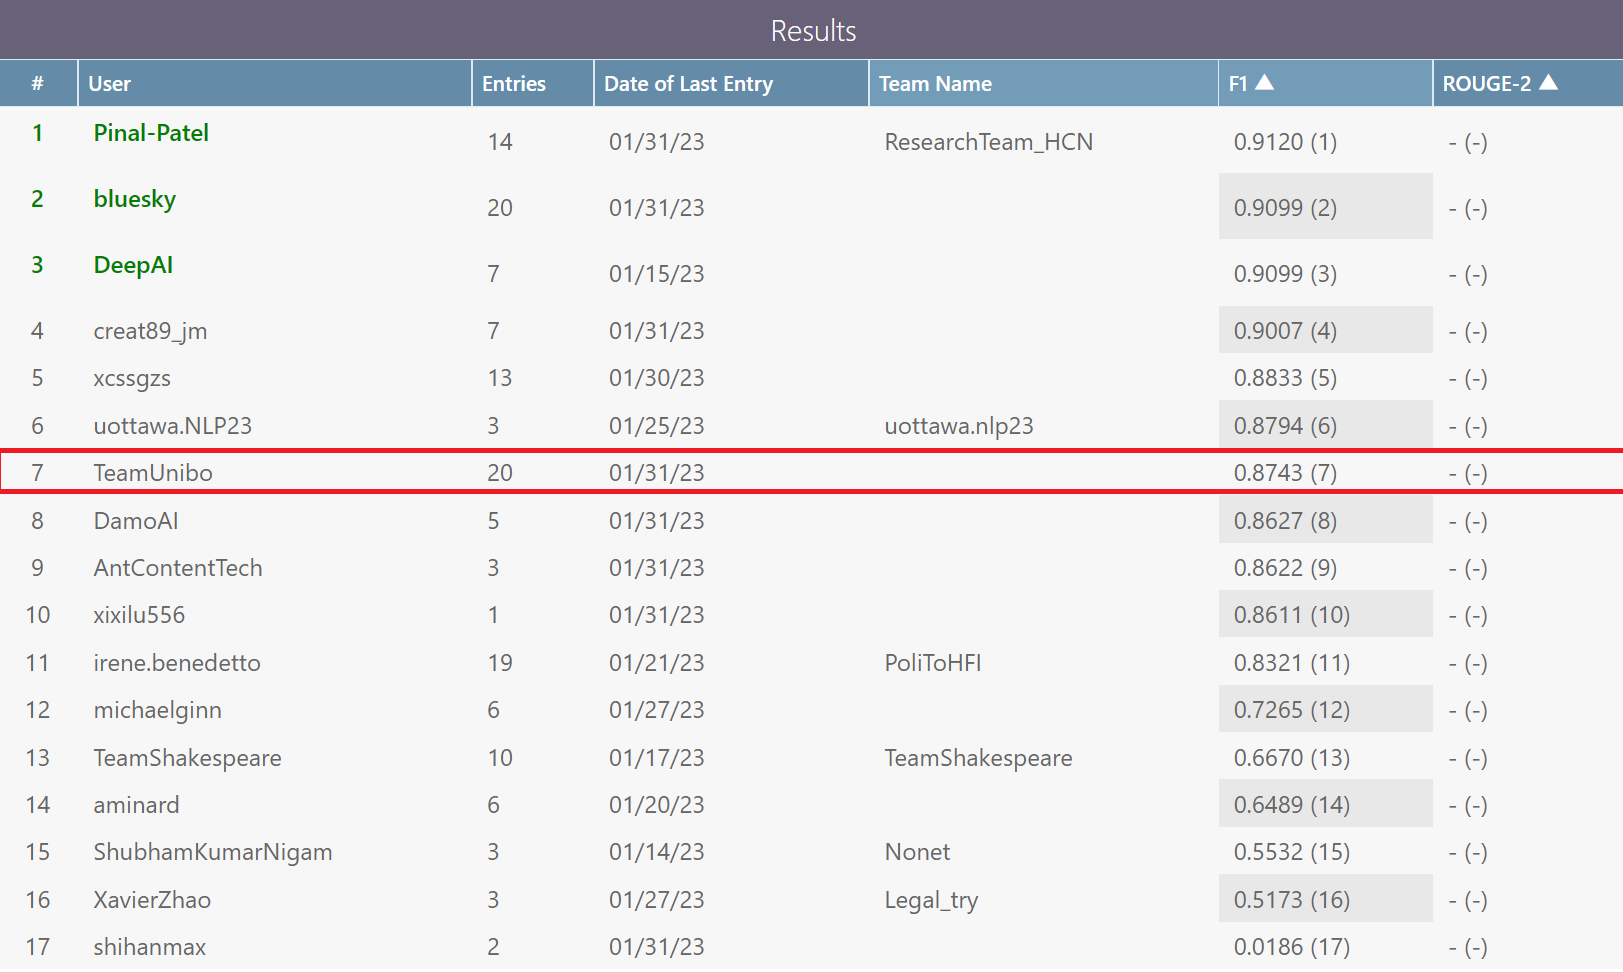

## Code for submission



For the final submission the best models were trained on the full dataset,
i.e. `train_df = pd.concat([train_df, val_df, test_df])`

Below there's our code to generate prediction for submission.

In [ ]:
sub_data = pd.read_json("/content/drive/MyDrive/project_nlp/NER_TEST_DATA_FS.json", encoding='utf-8')

In [ ]:
sub_data

,id,annotations,data,meta
0,0f8e4fc0fdff428f993cf8507f3606e4,[{'result': []}],{'text': 'In The High Court Of Kerala At Ernak...,{'source': 'criminal_kerala_high_court preambl...
1,9227e5004b52465289c7c3408f66b68a,[{'result': []}],{'text': '1 ...,{'source': 'motorvehicles_districtcourts pream...
2,fe8bb388cce041c78487cb7f56d9241c,[{'result': []}],{'text': 'The Honble Sri Justice Sanjay Kumar ...,{'source': 'civil_andhra_high_court preamble h...
3,ceb68187d16e4620b83bd8c133bd0d17,[{'result': []}],{'text': 'In The High Court Of Kerala At Ernak...,{'source': 'criminal_kerala_high_court preambl...
4,f79dc5f2f20546489015568978704c66,[{'result': []}],{'text': '* The Hon'Ble Sri Justice M. Satyana...,{'source': 'criminal_telangana_high_court prea...
...,...,...,...,...
4496,cc38d4b00e2f48a9b3342ea8d52efbc1,[{'result': []}],{'text': 'The learned counsel Sri. A.K. Bhat r...,{'source': 'motorvehicles_karnataka_high_court...
4497,a2dadc470cb1453cadd4655104749936,[{'result': []}],{'text': 'He and Dafedar Baljit Singh took the...,{'source': 'criminal_supremecourts judgement h...
4498,bd71c7fb30464217a35b70a54f490678,[{'result': []}],{'text': 'Even as per the evidence of defendan...,{'source': 'tax_andhra_high_court judgement ht...
4499,ca4b9a26b2784f2399e15d49c7e5a271,[{'result': []}],{'text': 'The action taken by the respondent-a...,{'source': 'tax_allahabad_high_court judgement...


Here we do inference with our best model on the submission data, some operations are done in order to respect the structure of submission that the challenge requires.

In [ ]:
custom_layers = {
    'LSTM' : 2,
    'CRF' : True
}

# model = AutoModelForTokenClassification.from_pretrained(os.path.join(root_dir, 'XLNet-new-fulldata'))

model = CustomXLNetForTokenClassification.from_pretrained(os.path.join(root_dir, 'XLNet-BiLSTM-2-CRF-fulldata'), custom_layers=custom_layers)  
tokenizer = AutoTokenizer.from_pretrained(os.path.join(root_dir, 'XLNet-BiLSTM-2-CRF-fulldata'), add_prefix_space=True, use_fast=True)

# pipe = SlidingWindowNERPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", window_length = 1024, device=0)
pipe = CrfSlidingWindowNERPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", window_length = 1024, device=0)

for _ , row in tqdm(sub_data.iterrows()):
  raw_text = row['data']['text']
  prediction = pipe(raw_text)
  # create the dictionary
  for pred in prediction:
    pred['word'] = raw_text[pred['start']:pred['end']]

    # sometimes the predicted boundaries do not match with the predicted text for
    # some whitespace or \n, we fix it for the submission.
     
    # remove left characters (spaces and \n)
    std_len = len(pred['word'])
    pred['word'] = pred['word'].lstrip()

    if len(pred['word']) < std_len:
      pred['start'] += std_len - len(pred['word'])

    # remove right characters
    std_len = len(pred['word'])
    pred['word'] = pred['word'].rstrip()

    if len(pred['word']) < std_len:
      pred['end'] -= std_len - len(pred['word'])
    
    pred_dict = dict()

    pred_dict['value'] = {
        'start' : pred['start'],
        'end' : pred['end'],
        'text' : pred['word'],
        'labels' : [pred['entity_group']] 
    }

    pred_dict['id'] = ''
    pred_dict['from_name'] = 'label'
    pred_dict['to_name'] = 'text'
    pred_dict['type'] = 'labels'

    row['annotations'][0]['result'].append(pred_dict)

loading configuration file /content/drive/MyDrive/project_nlp/XLNet-BiLSTM-2-CRF-fulldata/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "CustomXLNetForTokenClassification"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "O",
    "1": "B-CASE_NUMBER",
    "2": "B-COURT",
    "3": "B-DATE",
    "4": "B-GPE",
    "5": "B-JUDGE",
    "6": "B-LAWYER",
    "7": "B-ORG",
    "8": "B-OTHER_PERSON",
    "9": "B-PETITIONER",
    "10": "B-PRECEDENT",
    "11": "B-PROVISION",
    "12": "B-RESPONDENT",
    "13": "B-STATUTE",
    "14": "B-WITNESS",
    "15": "I-CASE_NUMBER",
    "16": "I-COURT",
    "17": "I-DATE",
    "18": "I-GPE",
    "19": "I-JUDGE",
    "20": "I-LAWYER",
    "21": "I-ORG",
    "22": "I-OTHER_PERSON",
    "23": "I-PETITIONER",

In [ ]:
sub_data

,id,annotations,data,meta
0,0f8e4fc0fdff428f993cf8507f3606e4,"[{'result': [{'value': {'start': 7, 'end': 40,...",{'text': 'In The High Court Of Kerala At Ernak...,{'source': 'criminal_kerala_high_court preambl...
1,9227e5004b52465289c7c3408f66b68a,"[{'result': [{'value': {'start': 71, 'end': 14...",{'text': '1 ...,{'source': 'motorvehicles_districtcourts pream...
2,fe8bb388cce041c78487cb7f56d9241c,"[{'result': [{'value': {'start': 23, 'end': 35...",{'text': 'The Honble Sri Justice Sanjay Kumar ...,{'source': 'civil_andhra_high_court preamble h...
3,ceb68187d16e4620b83bd8c133bd0d17,"[{'result': [{'value': {'start': 7, 'end': 40,...",{'text': 'In The High Court Of Kerala At Ernak...,{'source': 'criminal_kerala_high_court preambl...
4,f79dc5f2f20546489015568978704c66,"[{'result': [{'value': {'start': 26, 'end': 49...",{'text': '* The Hon'Ble Sri Justice M. Satyana...,{'source': 'criminal_telangana_high_court prea...
...,...,...,...,...
4496,cc38d4b00e2f48a9b3342ea8d52efbc1,"[{'result': [{'value': {'start': 25, 'end': 34...",{'text': 'The learned counsel Sri. A.K. Bhat r...,{'source': 'motorvehicles_karnataka_high_court...
4497,a2dadc470cb1453cadd4655104749936,"[{'result': [{'value': {'start': 7, 'end': 27,...",{'text': 'He and Dafedar Baljit Singh took the...,{'source': 'criminal_supremecourts judgement h...
4498,bd71c7fb30464217a35b70a54f490678,"[{'result': [{'value': {'start': 52, 'end': 60...",{'text': 'Even as per the evidence of defendan...,{'source': 'tax_andhra_high_court judgement ht...
4499,ca4b9a26b2784f2399e15d49c7e5a271,[{'result': []}],{'text': 'The action taken by the respondent-a...,{'source': 'tax_allahabad_high_court judgement...


In [ ]:
sub_data.to_json("/content/drive/MyDrive/project_nlp/submission_xlnet_bilstm-crf-fulldata.json", orient='records')